https://sccoda.readthedocs.io/en/latest/index.html
"the numerical value of these effects should not be used for analysis"

**Switching the reference cell type**

Compositional analysis generally does not allow statements on absolute abundance changes, but only in relation to a reference category, which is assumed to be unchanged in absolute abundance. The reference cell type fixes this category in scCODA. Thus, an interpretation of scCODA’s effects should always be formulated like: “Using cell type xy as a reference, cell types (a, b, c) were found to credibly change in abundance”

Switching the reference cell type might thus produce different results. For example, if we choose a different cell type as the reference, scCODA can find other credible effects on the other cell types.

## Import

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import arviz as az

2025-10-30 15:15:58.928045: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-30 15:15:59.526931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 15:16:02.407238: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
path = "output_phenotypes"

## Load

In [5]:
adata = sc.read_h5ad(os.path.join(path, 'adata_phenotype.h5ad'))

In [10]:
adata = adata[adata.obs['tissue_region'].isin(['core'])].copy()

In [12]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
patient_key = 'patient_id'

## Barplots

In [13]:
pastel_colors = cm.Pastel1(np.linspace(0, 1, 10))
tab10_colors = cm.tab10(np.linspace(0, 1, 10))
combined_colors = np.concatenate((tab10_colors, pastel_colors))

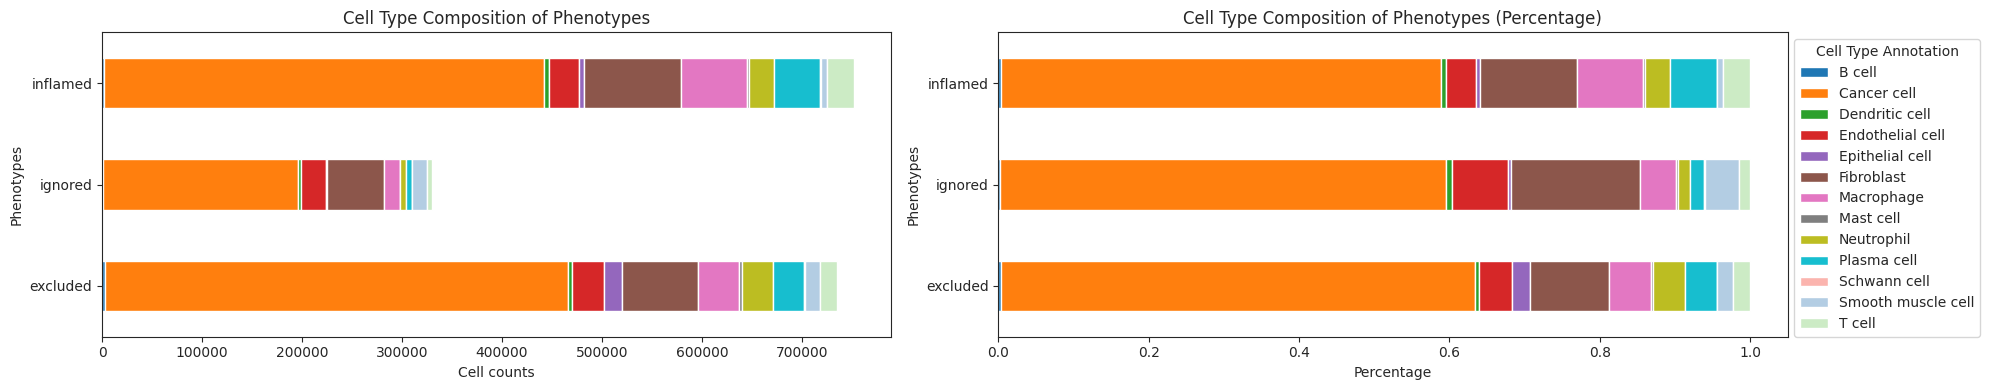

In [14]:
df_counts = (adata.obs.groupby([phenotype_key, cell_type_key]).size().unstack())
df_percent = df_counts.div(df_counts.sum(axis=1), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

df_counts.plot(kind="barh", stacked=True, ax=ax1, color=combined_colors[:len(df_counts.columns)],legend=False)
ax1.set_title("Cell Type Composition of Phenotypes")
ax1.set_xlabel("Cell counts")
ax1.set_ylabel("Phenotypes")

df_percent.plot(kind="barh", stacked=True, color=combined_colors[:len(df_percent.columns)], ax=ax2)
legend = ax2.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotation", prop={'size': 10})
ax2.set_title("Cell Type Composition of Phenotypes (Percentage)")
ax2.set_xlabel("Percentage")
ax2.set_ylabel("Phenotypes")

plt.tight_layout()
#plt.savefig(f"{figure_folder_path}/7_niches.svg", bbox_inches="tight")
plt.show()

In [15]:
df_percent

celltype,B cell,Cancer cell,Dendritic cell,Endothelial cell,Epithelial cell,Fibroblast,Macrophage,Mast cell,Neutrophil,Plasma cell,Schwann cell,Smooth muscle cell,T cell
phenotype,,,,,,,,,,,,,
excluded,0.003823,0.630685,0.004701,0.044026,0.024717,0.104120,0.055633,0.003053,0.043403,0.041657,0.000743,0.021446,0.021993
ignored,0.002881,0.592286,0.007856,0.075180,0.003251,0.172871,0.047297,0.002251,0.016006,0.018945,0.001518,0.045673,0.013985
inflamed,0.003278,0.585064,0.006678,0.040113,0.006316,0.128441,0.087773,0.003212,0.032491,0.062249,0.000467,0.007952,0.035966


In [ ]:
# IF MULTILEVEL
# reference_cell_type parameter is used to specify a cell type that is believed to be unchanged by the covariates
# cell type that has a nearly constant relative abundance over all samples
# It is also possible to let scCODA find a suited reference cell type by using reference_cell_type="automatic"
# formula="Cov1 + Cov2 + Cov3"
# model = mod.CompositionalAnalysis(adata_sccoda, formula="C(phenotype, Treatment('ignored'))", reference_cell_type="Schwann cell")

## scCODA - excluded vs inflamed

In [16]:
# retain only inflamed and exluded for now
adata_infl_excl = adata[adata.obs[phenotype_key].isin(['inflamed', 'excluded'])].copy()

In [17]:
cell_counts_per_patient_infl_excl = (adata_infl_excl.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_infl_excl[phenotype_key] = adata_infl_excl.obs.groupby(patient_key)[phenotype_key].first()

In [18]:
# Convert data to anndata object
adata_sccoda_infl_excl = dat.from_pandas(cell_counts_per_patient_infl_excl, covariate_columns=[phenotype_key])
adata_sccoda_infl_excl

AnnData object with n_obs × n_vars = 11 × 13
    obs: 'phenotype'

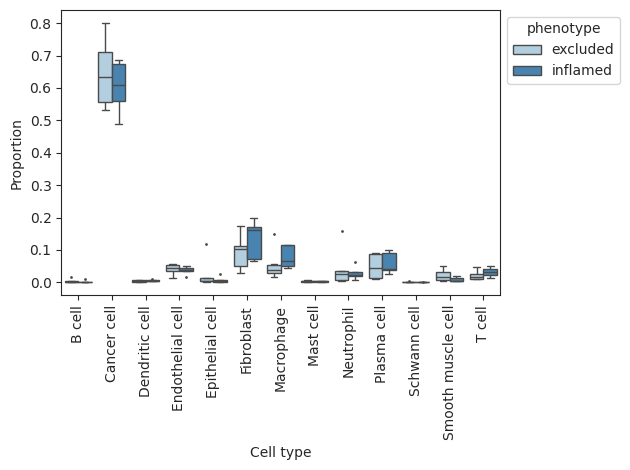

In [19]:
viz.boxplots(adata_sccoda_infl_excl, feature_name=phenotype_key)
plt.show()

In [24]:
model_infl_excl = mod.CompositionalAnalysis(adata_sccoda_infl_excl, formula=phenotype_key, reference_cell_type='Cancer cell')

In [25]:
results_infl_excl = model_infl_excl.sample_hmc(num_results=100000) # more repetitions

100%|██████████| 100000/100000 [07:44<00:00, 215.42it/s]


MCMC sampling finished. (492.033 sec)
Acceptance rate: 65.9%


In [50]:
results_infl_excl.set_fdr(est_fdr=0.45) # without: zero significant
results_infl_excl.summary()

Compositional Analysis summary:

Data: 11 samples, 13 cell types
Reference index: 1
Formula: phenotype

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
B cell                       -1.014       970.379618
Cancer cell                   3.466     85621.127964
Dendritic cell               -0.661      1381.171531
Endothelial cell              0.817      6055.288816
Epithelial cell              -0.449      1707.332267
Fibroblast                    1.591     13130.425240
Macrophage                    1.087      7932.213088
Mast cell                    -0.881      1108.416117
Neutrophil                    0.327      3709.629753
Plasma cell                   0.866      6359.387545
Schwann cell                 -1.365       683.131486
Smooth muscle cell           -0.070      2494.110306
T cell                        0.395      3970.658995


Effects:
                                          Final Parameter  Expected Sample  \


In [29]:
az.summary(results_infl_excl, var_names=["beta"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 95000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[phenotype[T.inflamed], B cell]",0.020,0.180,-0.334,0.434,0.002,0.002,6659.586,10794.845,NaN
"beta[phenotype[T.inflamed], Cancer cell]",0.000,0.000,0.000,0.000,0.000,NaN,95000.000,95000.000,NaN
"beta[phenotype[T.inflamed], Dendritic cell]",0.041,0.191,-0.288,0.509,0.002,0.002,6571.624,14977.203,NaN
"beta[phenotype[T.inflamed], Endothelial cell]",-0.009,0.138,-0.321,0.279,0.001,0.002,7928.145,16075.213,NaN
"beta[phenotype[T.inflamed], Epithelial cell]",-0.028,0.180,-0.452,0.301,0.002,0.003,6986.286,14826.193,NaN
"beta[phenotype[T.inflamed], Fibroblast]",0.142,0.213,-0.091,0.614,0.003,0.002,3691.611,3018.369,NaN
"beta[phenotype[T.inflamed], Macrophage]",0.119,0.215,-0.129,0.615,0.003,0.002,4573.688,10676.028,NaN
"beta[phenotype[T.inflamed], Mast cell]",0.022,0.181,-0.339,0.426,0.002,0.002,7183.264,16213.057,NaN
"beta[phenotype[T.inflamed], Neutrophil]",0.028,0.164,-0.268,0.422,0.002,0.002,7204.322,15297.930,NaN
"beta[phenotype[T.inflamed], Plasma cell]",0.072,0.182,-0.183,0.515,0.002,0.002,5046.062,12544.250,NaN


## scCODA - ignored vs inflamed

In [30]:
adata_infl_ign = adata[adata.obs[phenotype_key].isin(['inflamed', 'ignored'])].copy()

In [31]:
cell_counts_per_patient_infl_ign = (adata_infl_ign.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_infl_ign[phenotype_key] = adata_infl_ign.obs.groupby(patient_key)[phenotype_key].first()

In [32]:
# Convert data to anndata object
adata_sccoda_infl_ign = dat.from_pandas(cell_counts_per_patient_infl_ign, covariate_columns=[phenotype_key])
adata_sccoda_infl_ign

AnnData object with n_obs × n_vars = 9 × 13
    obs: 'phenotype'

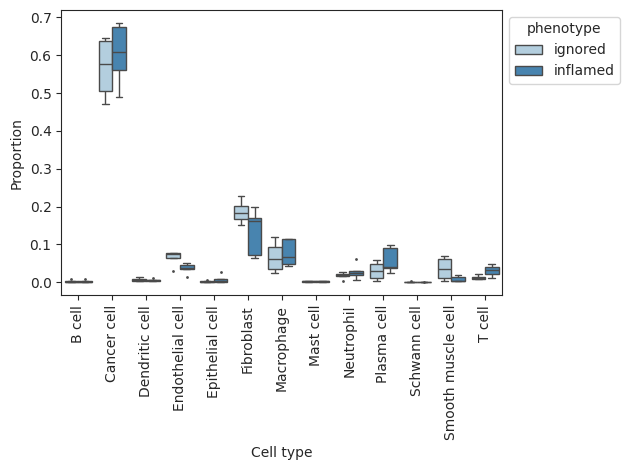

In [33]:
viz.boxplots(adata_sccoda_infl_ign, feature_name=phenotype_key)
plt.show()

In [34]:
model_infl_ign = mod.CompositionalAnalysis(adata_sccoda_infl_ign, formula=phenotype_key, reference_cell_type='Cancer cell')

In [35]:
results_infl_ign = model_infl_ign.sample_hmc(num_results=100000) # more repetitions

100%|██████████| 100000/100000 [07:34<00:00, 219.97it/s]


MCMC sampling finished. (480.199 sec)
Acceptance rate: 58.1%


In [42]:
results_infl_ign.set_fdr(est_fdr=0.4)  # without: zero significant
results_infl_ign.summary()

Compositional Analysis summary:

Data: 9 samples, 13 cell types
Reference index: 1
Formula: phenotype

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
B cell                       -0.895       649.294340
Cancer cell                   3.781     69695.159163
Dendritic cell               -0.206      1293.214349
Endothelial cell              1.411      6515.154097
Epithelial cell              -0.542       924.160855
Fibroblast                    2.558     20514.477633
Macrophage                    1.600      7870.572960
Mast cell                    -0.638       839.566882
Neutrophil                    0.527      2691.586678
Plasma cell                   0.848      3710.367257
Schwann cell                 -1.083       538.014839
Smooth muscle cell            0.346      2245.955095
T cell                        0.536      2715.920295


Effects:
                                          Final Parameter  Expected Sample  \
C

In [37]:
az.summary(results_infl_ign, var_names=["beta"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 95000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[phenotype[T.inflamed], B cell]",0.035,0.245,-0.438,0.616,0.002,0.003,9258.403,13203.659,NaN
"beta[phenotype[T.inflamed], Cancer cell]",0.000,0.000,0.000,0.000,0.000,NaN,95000.000,95000.000,NaN
"beta[phenotype[T.inflamed], Dendritic cell]",-0.012,0.223,-0.510,0.471,0.002,0.003,9984.790,15858.446,NaN
"beta[phenotype[T.inflamed], Endothelial cell]",-0.185,0.270,-0.789,0.118,0.003,0.002,5801.473,18199.292,NaN
"beta[phenotype[T.inflamed], Epithelial cell]",0.028,0.237,-0.464,0.557,0.002,0.003,9108.293,13957.429,NaN
"beta[phenotype[T.inflamed], Fibroblast]",-0.243,0.234,-0.693,0.021,0.004,0.001,4057.801,13596.563,NaN
"beta[phenotype[T.inflamed], Macrophage]",0.056,0.163,-0.180,0.476,0.002,0.002,10599.848,18592.128,NaN
"beta[phenotype[T.inflamed], Mast cell]",0.005,0.234,-0.516,0.507,0.002,0.003,9567.675,14924.085,NaN
"beta[phenotype[T.inflamed], Neutrophil]",0.068,0.222,-0.293,0.614,0.002,0.003,9516.860,15483.825,NaN
"beta[phenotype[T.inflamed], Plasma cell]",0.344,0.363,-0.087,1.049,0.005,0.002,4581.795,12144.361,NaN


## scCODA - ignored vs excluded

In [38]:
adata_excl_ign = adata[adata.obs[phenotype_key].isin(['excluded', 'ignored'])].copy()

In [39]:
cell_counts_per_patient_excl_ign = (adata_excl_ign.obs.groupby([patient_key, cell_type_key]).size().unstack())
cell_counts_per_patient_excl_ign[phenotype_key] = adata_excl_ign.obs.groupby(patient_key)[phenotype_key].first()

In [40]:
# Convert data to anndata object
adata_sccoda_excl_ign = dat.from_pandas(cell_counts_per_patient_excl_ign, covariate_columns=[phenotype_key])
adata_sccoda_excl_ign

AnnData object with n_obs × n_vars = 10 × 13
    obs: 'phenotype'

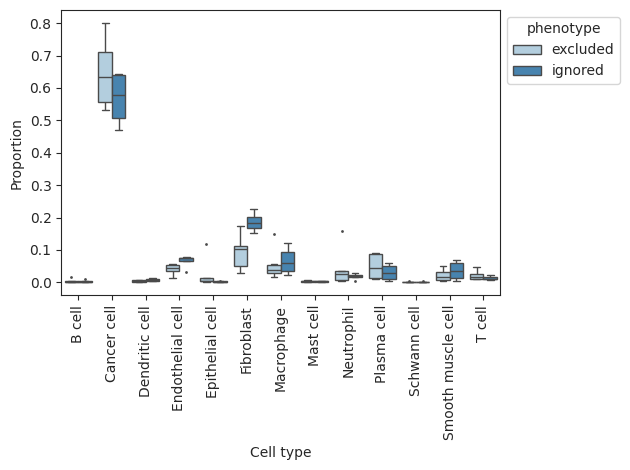

In [41]:
viz.boxplots(adata_sccoda_excl_ign, feature_name=phenotype_key)
plt.show()

In [43]:
model_excl_ign = mod.CompositionalAnalysis(adata_sccoda_excl_ign, formula=phenotype_key, reference_cell_type='Cancer cell')

In [44]:
results_excl_ign = model_excl_ign.sample_hmc(num_results=100000) # more repetitions

100%|██████████| 100000/100000 [08:17<00:00, 201.12it/s]


MCMC sampling finished. (523.028 sec)
Acceptance rate: 59.9%


In [48]:
results_excl_ign.set_fdr(est_fdr=0.4)
results_excl_ign.summary()

Compositional Analysis summary:

Data: 10 samples, 13 cell types
Reference index: 1
Formula: phenotype

Intercepts:
                    Final Parameter  Expected Sample
Cell Type                                           
B cell                       -1.138       747.744360
Cancer cell                   3.372     67986.276996
Dendritic cell               -0.717      1139.176777
Endothelial cell              0.887      5664.994230
Epithelial cell              -0.530      1373.422605
Fibroblast                    1.476     10209.369488
Macrophage                    0.918      5843.359428
Mast cell                    -0.940       911.472255
Neutrophil                    0.143      2692.057782
Plasma cell                   0.521      3928.689367
Schwann cell                 -1.302       634.642060
Smooth muscle cell            0.147      2702.847578
T cell                        0.120      2630.847075


Effects:
                                         Final Parameter  Expected Sample  \
C

In [46]:
az.summary(results_excl_ign, var_names=["beta"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 95000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[phenotype[T.ignored], B cell]",-0.003,0.253,-0.565,0.545,0.002,0.003,12914.106,20206.080,NaN
"beta[phenotype[T.ignored], Cancer cell]",0.000,0.000,0.000,0.000,0.000,NaN,95000.000,95000.000,NaN
"beta[phenotype[T.ignored], Dendritic cell]",0.088,0.284,-0.368,0.798,0.003,0.003,10795.563,18955.380,NaN
"beta[phenotype[T.ignored], Endothelial cell]",0.149,0.269,-0.185,0.777,0.003,0.002,8426.446,18654.469,NaN
"beta[phenotype[T.ignored], Epithelial cell]",-0.069,0.267,-0.692,0.410,0.002,0.003,11494.815,19397.868,NaN
"beta[phenotype[T.ignored], Fibroblast]",0.656,0.334,-0.001,1.172,0.004,0.003,5998.623,2377.200,NaN
"beta[phenotype[T.ignored], Macrophage]",0.084,0.217,-0.215,0.643,0.002,0.002,12199.757,22532.578,NaN
"beta[phenotype[T.ignored], Mast cell]",0.031,0.250,-0.444,0.649,0.002,0.003,12940.920,19739.273,NaN
"beta[phenotype[T.ignored], Neutrophil]",-0.014,0.217,-0.512,0.454,0.002,0.002,15102.227,21575.065,NaN
"beta[phenotype[T.ignored], Plasma cell]",-0.086,0.240,-0.673,0.290,0.002,0.002,11484.344,21959.636,NaN
